In [11]:
import gurobipy as gp
from gurobipy import GRB
import scipy
import pandas as pd
import numpy as np
import os

In [12]:
model = gp.Model("profit-optimization")

In [13]:
# 读取Excel文件
df1 = pd.read_excel('/home/maxdmx/math-China/附件1(1).xlsx')
column_name_1 = '地块名称'
column_data_1 = df1[column_name_1].tolist()

df2 = pd.read_excel('/home/maxdmx/math-China/附件1(2).xlsx')
column_name_2 = '作物名称'
column_data_2 =df2[column_name_2].tolist()
column_data_2

['黄豆',
 '黑豆',
 '红豆',
 '绿豆',
 '爬豆',
 '小麦',
 '玉米',
 '谷子',
 '高粱',
 '黍子',
 '荞麦',
 '南瓜',
 '红薯',
 '莜麦',
 '大麦',
 '水稻',
 '豇豆',
 '刀豆',
 '芸豆',
 '土豆',
 '西红柿',
 '茄子',
 '菠菜 ',
 '青椒',
 '菜花',
 '包菜',
 '油麦菜',
 '小青菜',
 '黄瓜',
 '生菜 ',
 '辣椒',
 '空心菜',
 '黄心菜',
 '芹菜',
 '大白菜',
 '白萝卜',
 '红萝卜',
 '榆黄菇',
 '香菇',
 '白灵菇',
 '羊肚菌']

In [14]:
years = [1,2,3,4,5,6,7]  # 2024到2030年
seasons = [1, 2]  # 两个种植季节
crops = list(range(1, 42))  # 41种作物
fields = list(range(1, 55))  # 54块地

In [15]:


# 定义决策变量，X[i][j][k] 表示第 i 作物在第 j 地块的第 k 季度种植面积
X = model.addVars(crops, fields,seasons,years, vtype=GRB.CONTINUOUS, name="X")

In [16]:
df3 = pd.read_excel('/home/maxdmx/math-China/附件2(2)1.xlsx')

npyields = np.zeros((42,55,3))
npcosts = np.zeros((42,55,3))
# 遍历每一行并提取所需的列
for index, row in df3.iterrows():
    crop_id = row['作物编号']        # 提取作物编号
    plot_type = row['地块类型']      # 提取地块类型
    planting_season = row['种植季次']  # 提取种植季次
    yield_per_acre = row['亩产量/斤']  # 提取亩产量
    cost_per_acre = row['种植成本/(元/亩)']
    if plot_type == '平旱地':
        listtemp1=[1,2,3,4,5,6]
    elif plot_type == '梯田':
        listtemp1=[7,8,9,10,11,12,13,14,15,16,17,18,19,20]
    elif plot_type == '山坡地':
        listtemp1=[21,22,23,24,25,26]
    elif plot_type == '水浇地':
        listtemp1=[27,28,29,30,31,32,33,34]
    elif plot_type == '普通大棚':
        listtemp1=[35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50]
    elif plot_type == '智慧大棚':
        listtemp1=[51,52,53,54]

    if planting_season=='单季' or planting_season=='第一季':
        ps=1
    else:
        ps=2
    for t in listtemp1:
        npyields[crop_id,t,ps]=yield_per_acre
        npcosts[crop_id,t,ps]=cost_per_acre
costs=npcosts.tolist()
yields=npyields.tolist()

In [17]:

df4 = pd.read_excel('/home/maxdmx/math-China/Ec.xlsx')

column_name_3 = '作物编号'
column_name_4 = '2023总产量'
column_data_3 = df4[column_name_3].tolist()
column_data_4 = df4[column_name_4].tolist()
npexpected_sales=np.zeros(42)
for i,j in zip(column_data_3,column_data_4):
    npexpected_sales[i]=j
expected_sales=npexpected_sales.tolist()

In [18]:


df5 = pd.read_excel('/home/maxdmx/math-China/updated_附件2(2)1.xlsx')
column_name_5 = '作物编号'
column_name_6 = '销售单价平均值/(元/斤)'
column_data_5 = df5[column_name_5].tolist()
column_data_5 = column_data_5[:-18]
column_data_6 = df5[column_name_6].tolist()
column_data_6 = column_data_6[:-18]
npprices=np.zeros(42)
for i,j in zip(column_data_5,column_data_6):
    npprices[i]=j
prices=npprices.tolist()

In [20]:
# 目标函数1: 滞销浪费情况下的利润最大化
objective = gp.quicksum(
    gp.quicksum(
        0.8 * gp.quicksum(
            gp.quicksum(yields[c][l][s] * X[c,l,s,y] for l in fields) for s in seasons
        ) * prices[c]
        - gp.quicksum(
            gp.quicksum(costs[c][l][s] * X[c,l,s,y] for l in fields) for s in seasons
        )
        for c in crops
    )
    for y in years
)

# 设置模型的目标函数为利润最大化
model.setObjective(objective, GRB.MAXIMIZE)

In [21]:
data = pd.read_excel('/home/maxdmx/math-China/附件1(1).xlsx')
field_areas = data['地块面积/亩'].to_numpy()
field_areas = np.insert(field_areas, 0, 0)
field_areas

array([ 0. , 80. , 55. , 35. , 72. , 68. , 55. , 60. , 46. , 40. , 28. ,
       25. , 86. , 55. , 44. , 50. , 25. , 60. , 45. , 35. , 20. , 15. ,
       13. , 15. , 18. , 27. , 20. , 15. , 10. , 14. ,  6. , 10. , 12. ,
       22. , 20. ,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,
        0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6])

In [22]:
# 约束条件1: 作物种植面积不能超过地块总面积

# 假设 field_areas 是一个字典，存储每块地的面积限制
for y in years:
    for s in seasons:
        for l in fields:
            # 添加约束：某块地 l 在某年 y 的某季节 s 上所有种植作物的总量 <= 该地块的面积
            model.addConstr(
                gp.quicksum(X[c, l, s, y] for c in crops) <= field_areas[l],
                name=f"field_area_constraint_{l}_{s}_{y}"
            )

            

# for y in years:
#         for c in crops:
#             model +=lpSum([lpSum([X[c][l][s][y]for s in seasons]) for l in fields]) <=260

# for y in years:
#         for c in crops:
#             model += lpSum([lpSum([yields[c] [l][s] * X[c][l][s][y] for l in fields]) for s in seasons])<=1.5*expected_sales[c]

In [23]:
# 约束条件2: 每个地块三年内至少种一次豆类作物
# beans1 = [1, 2, 3, 4, 5]
# for l in (1,27):
#     for y in years[:-2]:
#         model += lpSum([lpSum([X[bean][l][1][y + i] for i in range(0,3)])for bean in beans1])>=field_areas[l]
# beans2 = [16,17,18]
# for l in (27,42):
#     for y in years[:-2]:
#         model += lpSum([lpSum([lpSum([X[bean][l][s][y + i]for i in range(0,3)]) for bean in beans2]) for s in seasons])>=0.001

# # 约束条件2: 每个地块三年内至少种一次豆类作物
# beans = [1, 2, 3, 4, 5, 17, 18, 19] 
# for l in fields:
#     for s in seasons:
#         for y in years[:-2]:
#             model += lpSum([X[bean][l][s][y + i] for bean in beans for i in range(3)])>=field_areas[l]


# beans = [1, 2, 3, 4, 5, 17, 18, 19]
# for l in fields:
#     model += lpSum([X[bean][l][s][y] for bean in beans for s in seasons for y in years if y in range(years[0], years[-1]+3)]) >= field_areas[l]
beans1 = [1, 2, 3, 4, 5]
for l in [1, 27]:  # 地块编号 1 和 27
    for y in years[:-2]:  # 确保年份索引不超过边界
        # 添加约束：三年内至少种一次豆类作物，满足地块面积要求
        model.addConstr(
            gp.quicksum(gp.quicksum(X[bean, l, 1, y + i] for i in range(3)) for bean in beans1) >= field_areas[l],
            name=f"beans_constraint_{l}_{y}"
        )
beans2 = [16, 17, 18]
for l in range(27, 43):  # 地块编号 27 到 42
    for y in years[:-2]:  # 确保年份索引不超过边界
        # 添加约束：三年内至少种一次豆类作物，多个季节累计面积要求
        model.addConstr(
            gp.quicksum(gp.quicksum(gp.quicksum(X[bean, l, s, y + i] for i in range(3)) for bean in beans2) for s in seasons) >= 0.001,
            name=f"beans_season_constraint_{l}_{y}"
        )




In [24]:
#约束条件4:种植面积不能太小
#定义B数组           
# B = LpVariable.dicts("B", (crops, fields, seasons, years), cat = 'Binary')
# # 
# for c in crops:
#     for l in fields:
#         for s in seasons:
#             for y in years:
#                 if X[c][l][s][y] >= 0.001:
#                     B[c][l][s][y] = 1
#                 else:
#                     B[c][l][s][y] = 0
# 
# for l in fields:
#     for s in seasons:
#         for y in years:
#             model+= lpSum([X[c][l][s][y]*B[c][l][s][y] for c in crops])>=0.3


# 假设 X 已经用 addVars 创建
# 创建二进制变量 B[c, l, s, y]
B = model.addVars(crops, fields, seasons, years, vtype=GRB.BINARY, name="B")

# 定义大M值，假设X的最大值不会超过1
M = 1

# 添加约束，确保B和X的关系
for c in crops:
    for l in fields:
        for s in seasons:
            for y in years:
                # 约束1: X[c, l, s, y] >= 0.001 -> B[c, l, s, y] = 1
                model.addConstr(X[c, l, s, y] >= 0.001 * B[c, l, s, y], name=f"X_B_lower_{c}_{l}_{s}_{y}")
                
                # 约束2: X[c, l, s, y] < 0.001 -> B[c, l, s, y] = 0
                model.addConstr(X[c, l, s, y] <= M * B[c, l, s, y], name=f"X_B_upper_{c}_{l}_{s}_{y}")

# 添加约束：种植面积不能太小，即种植面积总和 >= 0.3
for l in fields:
    for s in seasons:
        for y in years:
            # 确保在每个地块、季节和年份，种植作物的面积满足条件
            model.addConstr(gp.quicksum(X[c, l, s, y] * B[c, l, s, y] for c in crops) >= 0.3, name=f"area_min_constraint_{l}_{s}_{y}")

In [25]:
# 约束条件3: 分散性约束，某个作物不能在太多地块种植
# max_field_count = 6  # 每个作物每季最多种6个地块
# for y in years:
#     for s in seasons:
#         for c in crops:
#             model += lpSum([B[c][l][s][y] for l in fields]) <= max_field_count


max_field_count = 6  # 每个作物每季最多种6个地块

for y in years:
    for s in seasons:
        for c in crops:
            # 限制每个作物在每年每季最多种植在 max_field_count 块地
            model.addConstr(
                gp.quicksum(B[c, l, s, y] for l in fields) <= max_field_count,
                name=f"field_count_constraint_{c}_{s}_{y}"
            )


In [26]:
# 约束条件5:轮作约束
# 对于平旱地
# for c in range(1,16):
#     for l in range(1,27):
#         for y in range(1,8):
#             model += X[c][l][1][y]*X[c][l][1][y+1] == 0
# #对于智慧大棚
# for c in range(1,16):
#     for l in range(51,55):
#         for y in range(1,8):
#             model += X[c][l][1][y]*X[c][l][1][y+1] +X[c][l][2][y]*X[c][l][2][y+1] == 0

# 约束条件5:轮作约束
# 对于平旱地
# for c in range(1,16):
#     for l in range(1,27):
#         for y in range(1,7):
#             model += X[c][l][1][y]+X[c][l][1][y+1] <= field_areas[l]
# # #对于智慧大棚
# for c in range(1,16):
#     for l in range(51,55):
#         for y in range(1,7):
#             model += X[c][l][1][y]+X[c][l][1][y+1] +X[c][l][2][y]+X[c][l][2][y+1] <=field_areas[l]

# 约束条件5:轮作约束
# 对于平旱地
# for c in range(1,16):
#     for l in range(1,27):
#         for y in range(1,7):
#             model += X[c][l][1][y]+X[c][l][1][y+1] <= field_areas[l]
# # #对于智慧大棚
# for c in range(17,35):
#     for l in range(51,55):
#         for y in range(1,7):
#             model += X[c][l][1][y]+X[c][l][2][y+1]  <=field_areas[l]
#             model+=  X[c][l][2][y]+X[c][l][1][y+1] <=field_areas[l]
#             model+=  X[c][l][1][y]+X[c][l][1][y+1] <=field_areas[l]



# 对于平旱地，作物 1-15, 地块 1-26, 限制相邻年份的同一地块不种同一作物
for c in range(1, 16):  # 作物范围
    for l in range(1, 27):  # 地块范围
        for y in range(1, 7):  # 年份范围，注意 y+1 不能超出范围
            # 添加约束：相邻年份不能种植相同作物
            model.addConstr(B[c, l, 1, y] + B[c, l, 1, y + 1] <= 1, name=f"rotation_constraint_flatland_{c}_{l}_{y}")
# 对于智慧大棚，作物 1-15, 地块 51-54, 限制相邻年份的同一地块不种同一作物
for c in range(1, 16):  # 作物范围
    for l in range(51, 55):  # 智慧大棚地块范围
        for y in range(1, 7):  # 年份范围
            # 添加约束：相邻年份的任一季节不能种植相同作物
            model.addConstr(B[c, l, 1, y] + B[c, l, 2, y ] <= 1, name=f"rotation_constraint_smart_greenhouse_{c}_{l}_{y}")


In [27]:
# 种植类别约束
# 对于平旱地，梯田，山坡:
# for c in range(1,16):
#     for l in range(1,27):
#             for y in years:
#                 model += X[c][l][ 2][ y] == 0 
# 
# for c in range(17,42):
#      for l in range(1,27):
#           for s in range(1,3):
#             for y in years:
#                 model += X[c][l][ s][ y] == 0 
                
                
# 对于作物 1-15，地块 1-26，第二季节不允许种植
for c in range(1, 16):  # 作物范围 1-15
    for l in range(1, 27):  # 地块范围 1-26
        for y in years:  # 年份
            # 添加约束：第二季节不能种植这些作物
            model.addConstr(X[c, l, 2, y] == 0, name=f"season2_no_planting_{c}_{l}_{y}")

# 对于作物 17-41，地块 1-26，两个季节都不允许种植
for c in range(17, 42):  # 作物范围 17-41
    for l in range(1, 27):  # 地块范围 1-26
        for s in range(1, 3):  # 季节 1 和 2
            for y in years:  # 年份
                # 添加约束：这类作物不能在任何季节种植
                model.addConstr(X[c, l, s, y] == 0, name=f"no_planting_{c}_{l}_{s}_{y}")


In [28]:

# 对于水浇地:
# for l in range(27,35):
#      for y in years:
#           for c in range(1,17):
#               model += X[c][l][ 1][ y]==0
#           for c in range(35,42):
#               model += X[c][l][ 1][ y]==0
#           for c in range(1,35):
#                model += X[c][l][ 2][ y]==0
#           for c in range(38,42):
#                model += X[c][l][ 2][ y]==0
# #对于普通大棚类:
# for l in range(35,51):
#      for y in years:
#           for c in range(1,17):
#               model += X[c][l][1][y]==0
#           for c in range(35,42):
#               model += X[c][l][ 1][ y]==0
#           for c in range(1,38):
#               model += X[c][l][ 2][ y]==0
# #对于智慧大棚类:
# for l in range(51,55):
#      for s in range(1,3):
#         for y in years:
#              for c in range(1,17):
#                  model += X[c][l][ s][ y]==0
#              for c in range(35,42):
#                  model += X[c][l][ s][ y]==0 

# 对于水浇地 (地块 27-34):
for l in range(27, 35):  # 地块 27 到 34
    for y in years:
        # 第一季节不允许种植作物 1-16
        for c in range(1, 17):
            model.addConstr(X[c, l, 1, y] == 0, name=f"irrigated_land_season1_no_planting_{c}_{l}_{y}")
        
        # 第一季节不允许种植作物 35-41
        for c in range(35, 42):
            model.addConstr(X[c, l, 1, y] == 0, name=f"irrigated_land_season1_no_planting_{c}_{l}_{y}")

        # 第二季节不允许种植作物 1-34
        for c in range(1, 35):
            model.addConstr(X[c, l, 2, y] == 0, name=f"irrigated_land_season2_no_planting_{c}_{l}_{y}")

        # 第二季节不允许种植作物 38-41
        for c in range(38, 42):
            model.addConstr(X[c, l, 2, y] == 0, name=f"irrigated_land_season2_no_planting_{c}_{l}_{y}")

# 对于普通大棚 (地块 35-50):
for l in range(35, 51):  # 地块 35 到 50
    for y in years:
        # 第一季节不允许种植作物 1-16
        for c in range(1, 17):
            model.addConstr(X[c, l, 1, y] == 0, name=f"regular_greenhouse_season1_no_planting_{c}_{l}_{y}")
        
        # 第一季节不允许种植作物 35-41
        for c in range(35, 42):
            model.addConstr(X[c, l, 1, y] == 0, name=f"regular_greenhouse_season1_no_planting_{c}_{l}_{y}")

        # 第二季节不允许种植作物 1-37
        for c in range(1, 38):
            model.addConstr(X[c, l, 2, y] == 0, name=f"regular_greenhouse_season2_no_planting_{c}_{l}_{y}")

# 对于智慧大棚 (地块 51-54):
for l in range(51, 55):  # 地块 51 到 54
    for s in range(1, 3):  # 季节 1 和 2
        for y in years:
            # 不允许种植作物 1-16
            for c in range(1, 17):
                model.addConstr(X[c, l, s, y] == 0, name=f"smart_greenhouse_no_planting_{c}_{l}_{s}_{y}")
            
            # 不允许种植作物 35-41
            for c in range(35, 42):
                model.addConstr(X[c, l, s, y] == 0, name=f"smart_greenhouse_no_planting_{c}_{l}_{s}_{y}")


In [933]:
# for l in range(0,55):
#     for s in range(0,3):
#         for y in range(0,8):
#             model += X[0][l][s][y]==0
# for c in range(0,42):
#     for s in range(0,3):
#         for y in range(0,8):
#             model += X[c][0][s][y]==0
# for l in range(0,55):
#     for c in range(0,42):
#         for y in range(0,8):
#             model += X[c][l][0][y]==0
# for l in range(0,55):
#     for s in range(0,3):
#         for c in range(0,42):
#             model += X[0][l][s][0]==0

In [29]:
model.optimize()

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Core(TM) i9-14900HX, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 32 logical processors, using up to 32 threads


GurobiError: Model too large for size-limited license; visit https://gurobi.com/unrestricted for more information

In [935]:
# 假设 crops, fields, seasons, years 是已定义的作物、地块、季节和年份集合
for c in crops:
    for l in fields:
        for s in seasons:
            for y in years:
                # 打印变量名称和求解后的值
                print(f"X[{c}][{l}][{s}][{y}] = {X[c][l][s][y].varValue}")


X[1][1][1][1] = 0.0
X[1][1][1][2] = 0.0
X[1][1][1][3] = 0.0
X[1][1][1][4] = 0.0
X[1][1][1][5] = 0.0
X[1][1][1][6] = 0.0
X[1][1][1][7] = 0.0
X[1][1][2][1] = 0.0
X[1][1][2][2] = 0.0
X[1][1][2][3] = 0.0
X[1][1][2][4] = 0.0
X[1][1][2][5] = 0.0
X[1][1][2][6] = 0.0
X[1][1][2][7] = 0.0
X[1][2][1][1] = 0.0
X[1][2][1][2] = 0.0
X[1][2][1][3] = 0.0
X[1][2][1][4] = 0.0
X[1][2][1][5] = 0.0
X[1][2][1][6] = 0.0
X[1][2][1][7] = 0.0
X[1][2][2][1] = 0.0
X[1][2][2][2] = 0.0
X[1][2][2][3] = 0.0
X[1][2][2][4] = 0.0
X[1][2][2][5] = 0.0
X[1][2][2][6] = 0.0
X[1][2][2][7] = 0.0
X[1][3][1][1] = 0.0
X[1][3][1][2] = 0.0
X[1][3][1][3] = 0.0
X[1][3][1][4] = 0.0
X[1][3][1][5] = 0.0
X[1][3][1][6] = 0.0
X[1][3][1][7] = 0.0
X[1][3][2][1] = 0.0
X[1][3][2][2] = 0.0
X[1][3][2][3] = 0.0
X[1][3][2][4] = 0.0
X[1][3][2][5] = 0.0
X[1][3][2][6] = 0.0
X[1][3][2][7] = 0.0
X[1][4][1][1] = 0.0
X[1][4][1][2] = 0.0
X[1][4][1][3] = 0.0
X[1][4][1][4] = 0.0
X[1][4][1][5] = 0.0
X[1][4][1][6] = 0.0
X[1][4][1][7] = 0.0
X[1][4][2][1] = 0.0


In [936]:
array_4d = [[[[0 for y in range(1,8)] for s in range(1,3)] for l in range(1,55)] for c in range(1,42)]
for c in crops:
    for l in fields:
        for s in seasons:
            for y in years:
                array_4d[c-1][l-1][s-1][y-1]= X[c][l][s][y].varValue
array_4d = np.array(array_4d)
X[13][9][1][7].varValue

0.0

In [937]:
array_4d.shape

(41, 54, 2, 7)

In [938]:
arr_transposed = np.transpose(array_4d, (3, 2, 1, 0))
arr_transposed.size

30996

In [939]:
array_3d=arr_transposed[6,:,:,:]
array_2d=array_3d.reshape((54*2,41))
# 将 numpy 数组转换为 pandas DataFrame
df = pd.DataFrame(array_2d)

# 将 DataFrame 写入 Excel 文件的 sheet1
df.to_excel('output7.xlsx', sheet_name='Sheet1', index=False)    
print("数据已写入 Excel 文件")

数据已写入 Excel 文件


In [940]:
P=np.zeros((7))
for y in years:
    for c in crops:
        sales=0
        for s in seasons:
            for l in fields:
                # 计算每个作物的销售量和利润
                sales += 0.8*yields[c][l][s] * array_4d[c-1][l-1][s-1][y-1]
        Cost=0
        for s in seasons: 
            for l in fields:
                Cost+=costs[c][l][s]*array_4d[c-1][l-1][s-1][y-1]
        P[y-1] += sales * prices[c] - Cost
print(P)

[5795586.29749596 5795586.2805002  5795586.286408   5795586.2831646
 5795586.2957978  5795586.281468   5795586.279748  ]


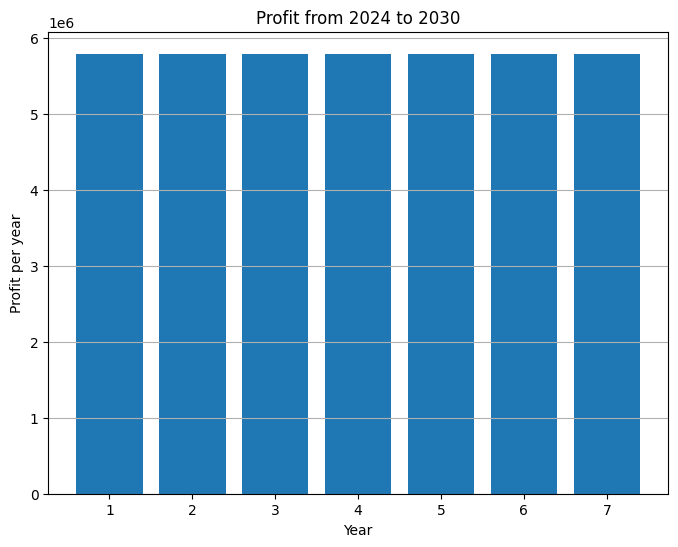

In [941]:
import numpy as np
import matplotlib.pyplot as plt
years1=[2024,2025,2026,2027,2028,2029,2030]
# Plotting a bar chart
plt.figure(figsize=(8, 6))
plt.bar(years, P)
plt.xlabel('Year')
plt.ylabel('Profit per year')
plt.title('Profit from 2024 to 2030')
plt.xticks(years)  # Ensure the x-axis shows each year
plt.grid(axis='y')

# Show the plot
plt.show()
